<a href="https://colab.research.google.com/github/pushyag1/DeepLearningClass/blob/master/Chapter_6_Common_Design_Building_Blocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
from torchvision import transforms

from torch.utils.data import Dataset, DataLoader

from tqdm.autonotebook import tqdm

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import pandas as pd

from sklearn.metrics import accuracy_score

import time

from google.colab import drive
drive.mount('/content/gdrive/')
import sys
sys.path.append('/content/gdrive/My Drive/MPDL Fall 2020/')

from mpdl import train_network, Flatten, weight_reset, set_seed
from mpdl import LanguageNameDataset, pad_and_pack, EmbeddingPackable, LastTimeStep

Mounted at /content/gdrive/


In [ ]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

In [ ]:
torch.backends.cudnn.deterministic=True
set_seed(42)

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

At this point in time, we have learned about the three most common and fundamental types of neural networks. Fully Connected, Convolutional, and Recurrent. We have been able to improve all of these architectures by changing the optimizer and learning rate schedule, getting faster and more accurate models "for free". Now that we have these better tools for training our models, we can start learning about newer approaches to designing neural networks. Many of these newer methods _would not work_ without the improvements to learning like `Adam` we discussed in the last chapter, which is why we are only talking about them now! 

Many of the new methods we will discuss have become the fundamental building blocks to modern deep learning architectures. For this reason we are going to spend time talking about _why_ each of these new techniques work, so that you can learn to recognize the logic and reasoning behind them and start to develop your own intuition about how you might make your own changes. These techniques are also important to understand because many new methods that are developed are variants to the ones we will learn about in this chapter. 

We will talk about five new types methods in this chapter that work for feed-forward models, and one new improvement to RNNs as the end. For the first five methods we will introduce them roughly in the order that they were invented, as each tends to always use the preceding item's in their design. So we will start with a new activation function called a Rectified Linear Unit or "ReLU". Then we will sandwich a new type of "normalization" layer in between our linear/convoultion layers and our non-linear activation layers. After that. We will learn about two types of design choices that re-use the layers we already know about. These techniques are called skip-connections and $1\times1$ convolution, and while not always useful on their own, they can be combined into the fifth method known as a _Residual Layer_, which becomes more than the sum of it's parts! All of these individually and together have the goals of helping our networks learn faster, and learn more accurate solutions. We'll end by introducing  the Long Short Term Memory (LSTM) layer as an alternative to the RNN layer we were using before, which has been the workhorse of RNNs for over 20 years! 

Below I'm going to load up the FashionMNIST dataset again, since it is hard enough for us to see improvements but easy enough that we don't have to wait a long time for the results. 

In [ ]:
train_data = torchvision.datasets.FashionMNIST("./", train=True, transform=transforms.ToTensor(), download=True)
test_data = torchvision.datasets.FashionMNIST("./", train=True, transform=transforms.ToTensor(), download=True)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128)

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw


Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw
Processing...
Done!





/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


This chapter will be a little different in that we are going to train fully-connected and convolutional networks for almost every example. This is because the code for some of the techniques we are going to learn about looks a little different for each type of network. So below we have the code specifying our features, number of hidden neurons for the fully-connected layers, the number of channels and filters for the convolutional network, and the total number of classes. 

In [ ]:
#Whats the width and height of our images?
W, H = 28, 28 #
#How many values are in the input? We use this to help determine the size of subsequent layers
D = 28*28 #28 * 28 images 
#Hidden layer size
n = 256 
#How many channels are in the input?
C = 1
#how many filters per convolutional layer
n_filters = 32
#How many classes are there?
classes = 10#

Finally our baseline fully-connected model `fc_model` and our convolutional model `cnn_model` are defined below. I'm adding a few more layers for each than we used in previous chapters, and defining them in a way that is a reasonable first approach for a new problem. Well take turns adding our new building blocks to these two architectures throughout this chapter so that we can see how each change improves the results we get. 

In [ ]:

fc_model = nn.Sequential(
    Flatten(),
    nn.Linear(D,  n),
    nn.Tanh(),
    nn.Linear(n,  n),
    nn.Tanh(),
    nn.Linear(n,  n),
    nn.Tanh(),
    nn.Linear(n,  n),
    nn.Tanh(),
    nn.Linear(n,  n),
    nn.Tanh(),
    nn.Linear(n,  n),
    nn.Tanh(),
    nn.Linear(n, classes),
)

cnn_model = nn.Sequential(
    nn.Conv2d(C, n_filters, (3,3), padding=1), 
    nn.Tanh(),
    nn.Conv2d(n_filters, n_filters, (3,3), padding=1), 
    nn.Tanh(),
    nn.Conv2d(n_filters, n_filters, (3,3), padding=1), 
    nn.MaxPool2d((2,2)),
    nn.Tanh(),
    nn.Conv2d(n_filters, 2*n_filters, (3,3), padding=1), 
    nn.Tanh(),
    nn.Conv2d(2*n_filters, 2*n_filters, (3,3), padding=1), 
    nn.Tanh(),
    nn.Conv2d(2*n_filters, 2*n_filters, (3,3), padding=1), 
    nn.MaxPool2d((2,2)),
    nn.Tanh(),
    nn.Conv2d(2*n_filters, 4*n_filters, (3,3), padding=1), 
    nn.Tanh(),
    nn.Conv2d(4*n_filters, 4*n_filters, (3,3), padding=1), 
    nn.Tanh(),
    Flatten(),
    nn.Linear(D*n_filters//4, classes),
)

We will use our new `train_network` function to train all of the models from this point forward. Remember that we modified this method to use the `AdamW` optimizer by default, so we don't have to specify that. 

In [ ]:
loss_func = nn.CrossEntropyLoss()

In [ ]:
fc_results = train_network(fc_model, loss_func, train_loader, val_loader=test_loader, epochs=10,
                                 score_funcs={'Accuracy': accuracy_score}, device=device)
cnn_results = train_network(cnn_model, loss_func, train_loader, val_loader=test_loader, epochs=10,
                                 score_funcs={'Accuracy': accuracy_score}, device=device)

Last a small change, I'm going to use the `del` command to delete some of our neural networks once we are done with them in this chapter. This is because if you are unlucky and get one of the lower-end GPUs from colab, you might run out of memory running these examples. So I'll just be explicit and tell Python we are done so that we can get the GPU memory back and avoid such annoyances. 

In [ ]:
del fc_model
del cnn_model

And now our initial results! Unsurprisingly the CNN performs much better than the fully connected network. We expect this because we are working with images, and as we learned in chapter 3 convoltuional layers are a powerful way of encoding the "structural prior" about pixels and their relationships into our network. 

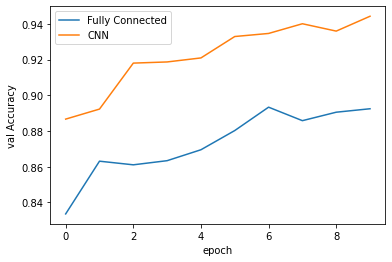

In [ ]:
sns.lineplot(x='epoch', y='val Accuracy', data=fc_results, label='Fully Connected')
sns.lineplot(x='epoch', y='val Accuracy', data=cnn_results, label='CNN')

With these results in hand, we can dive into the rest of this chapter! Well spend each section talking about a new kind of `Module` you can use in your neural networks, the intuition or reason for why we would want to do it, and then apply it to our baseline networks above. 

# Better Activation Functions

We have been relying very heavily on the $\tanh(\cdot)$ activation function, and to a smaller degree the sigmoid function $\sigma(\cdot)$, throughout this book. They are two of the original activation functions that were used for neural networks, but they are not the only options. Currently, we as a community don't really know what definitively makes one activation function better than another. But have learned about somethings that are undesirable in an activation function. In the case of $\tanh(\cdot)$ and $\sigma(\cdot)$ they both can lead to a problem called "vanishing gradients". 

Remember that everything architecture we define learns by treating the network as one giant function $f_\Theta(\boldsymbol{x})$, where we need to use the gradient ($\nabla$) with respect to the parameters ($\Theta$) of $f$ to adjust its weights according to a loss function $\ell(\cdot, \cdot)$. So we perform:

$$\Theta_{t+1} = \Theta_{t} - \eta \cdot \nabla_{\Theta_{t}} f_{\Theta_{t}}(\boldsymbol{x})$$

But what if $\nabla_\Theta f_\Theta(\boldsymbol{x})$ is very small? If that happens, there will be almost no change in the value of $\Theta$, and thus, no learning! 

$$\Theta_{t+1} = \Theta_{t} - \eta \cdot \underbrace{\nabla_{\Theta_{t}} f_{\Theta_{t}}(\boldsymbol{x})}_{\approx 0}$$

$$\Theta_{t+1} \approx \Theta_{t} - \eta \cdot 0 = \Theta_t$$

While momentum from the last chapter can help with this problem, it would be better if the gradients never vanished in the first place. This is because as the math shows us, if we get too close to zero these is nothing to do. 

How do the tanh and sigmoid activations result in this vanishing gradient problem? Lets plot both of these function again below. 

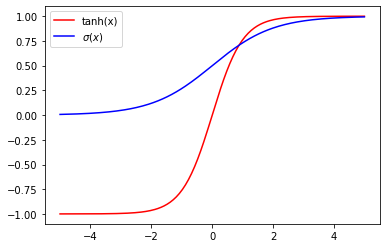

In [ ]:
def sigmoid(x):
    return np.exp(activation_input)/(np.exp(activation_input)+1)

activation_input = np.linspace(-5, 5, num=200)
tanh_activation = np.tanh(activation_input)
sigmoid_activation = sigmoid(activation_input)

sns.lineplot(x=activation_input, y=tanh_activation, color='red', label="tanh(x)")
sns.lineplot(x=activation_input, y=sigmoid_activation, color='blue', label="$\sigma(x)$")

Both of these activations have a property called "saturation". Saturation is when the activation stops changing as the input keeps changing. For both $\tanh(\cdot)$ and $\sigma(\cdot)$ if the input $x$ keeps getting larger, both activations will saturate at the value of $1.0$. So if the input to the activation is $100$ and you double the input value, you are still going to get a value of (almost) $1.0$ from the output. Thats what saturation is. Both of these activations also saturate on the left hand size of the plot, so when the input $x$ becomes very small $\tanh(\cdot)$ will saturate at $-1.0$ and $\sigma(\cdot)$ will saturate at $0$. 

Now let's plot the derivatives of these functions below, where we will see that saturation has an undesirable result.  

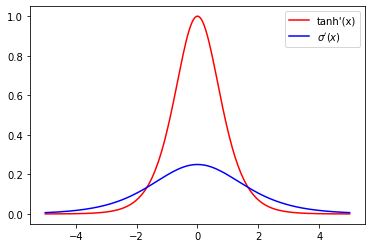

In [ ]:
def tanh_deriv(x):
    return 1.0 - np.tanh(x)**2
def sigmoid_derivative(x):
    return sigmoid(x)*(1-sigmoid(x))

tanh_deriv = tanh_deriv(activation_input)
sigmoid_deriv = sigmoid_derivative(activation_input)

sns.lineplot(x=activation_input, y=tanh_deriv, color='red', label="tanh'(x)")
sns.lineplot(x=activation_input, y=sigmoid_deriv, color='blue', label="$\sigma'(x)$")

Do you see the problem in the above plot? As the activation _begins to saturate, its gradient begins to vanish_ !This will happen with _any_ activation function that saturates. Since our weight changes based on the value of the gradient $\nabla$, this means our network will stop learning if too many neurons start saturating. 

Now this does not mean that you should never use $\tanh(\cdot)$ and $\sigma(\cdot)$, there are actually some cases were you want saturation (well see an example of that at the end of this chapter)! But if you you don't _want_ saturation, why pay the price of a vanishing gradient? 

## Rectified Linear Units

Now we know that an activation function that saturates, by default, is probably not a great activation function to be using. So what should we use instead? The most common approach to fix this is to use an activation function known as the _Rectified Linear Unit_ (ReLU), which has a very simple definition:

$$\text{ReLU}(x) = \max(0, x)$$

Thats all the ReLU does! If the input is positive, return it unaltered. If the input is negative, return zero instead. This may seem surprising, as we have harped on the importance of having a non-linearity. But it turns out, almost _any_ non-linearity is sufficient for us to learn from. Choosing a simple activation function like this also leads to a simple derivative:

$$
 \text{ReLU}'(x) =
\begin{cases}
1,  & \text{if $x>0$} \\
0, & \text{otherwise}
\end{cases}
$$

And thats all it takes! For half of all possible inputs, the ReLU has a constant value as its derivative. On its own, the ReLU usually performs much better than the $tanh(\cdot)$ or sigmoid activations. However, the ReLU often performs worse for very small networks. 

The reason why? Instead of having a _vanishing_ gradient, the ReLU has _no_ gradient for $x <= 0$! If you have a lot of neurons it is _ok_ if some of them "die" and stop activating, but if you don't have enough extra neurons it becomes a serious problem. This can again be solved by adding a simple modification: instead of returning $0$ for negative inputs, lets return something else. This leads us to what is called the _Leaky ReLU_. The Leaky ReLU takes a "leaking" factor $\alpha$, which is supposed to be small. Values in the range $\alpha \in [0.01, 0.3]$ are often used, and the specific value has relatively little impact in most cases. 

So what is the mathematical definition of the Leaky ReLU? Again, it is a simple change with its activation and derivative defined as: 


$$\text{LeakyReLU}(x) = \max(\alpha \cdot x, x)$$


$$
 \text{LeakyReLU}'(x) =
\begin{cases}
1,  & \text{if $x>0$} \\
\alpha, & \text{otherwise}
\end{cases}
$$

The intuition to an improved ReLU is that there is a hard "floor" when $x <= 0$. Because there is no change at this floor's level, there is no gradient. Instead, we would like the floor to "leak", so that it changes - but slowly. If it changes even just a little bit, we can get a gradient. Below lets plot all of these activations and see what they look like. 




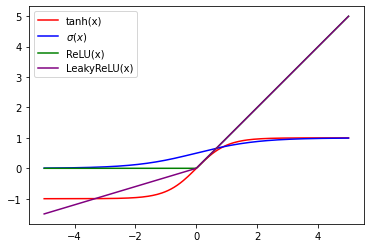

In [ ]:
activation_input = np.linspace(-5, 5, num=200)
relu_activation = np.maximum(0,activation_input)
leaky_relu_activation = np.maximum(0.3*activation_input,activation_input)

sns.lineplot(x=activation_input, y=tanh_activation, color='red', label="tanh(x)")
sns.lineplot(x=activation_input, y=sigmoid_activation, color='blue', label="$\sigma(x)$")
sns.lineplot(x=activation_input, y=relu_activation, color='green', label="ReLU(x)")
sns.lineplot(x=activation_input, y=leaky_relu_activation, color='purple', label="LeakyReLU(x)")

We can see clearly that to the right as the input gets larger, ReLU and LeakyReLU behave in a linear fashion --- just increasing with the input. To the left as the input gets smaller, both are _still_ linear, but ReLU is stuck at zero, and LeakyReLU is decreasing. The non-linearity for both is simply changing the slope of the line, which is enough. Now lets look at the gradients. 

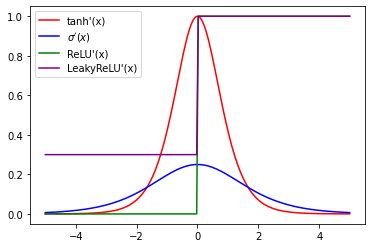

In [ ]:
relu_deriv = 1.0*(activation_input > 0)
leaky_deriv = 1.0*(activation_input > 0) + 0.3*(activation_input <= 0)

sns.lineplot(x=activation_input, y=tanh_deriv, color='red', label="tanh'(x)")
sns.lineplot(x=activation_input, y=sigmoid_deriv, color='blue', label="$\sigma'(x)$")
sns.lineplot(x=activation_input, y=relu_deriv, color='green', label="ReLU'(x)")
sns.lineplot(x=activation_input, y=leaky_deriv, color='purple', label="LeakyReLU'(x)")

So the LeakyReLU has gradient values that will _never_ vanish on their own, but that does not mean it is a better activation function. We need the activation to introduce a non-linear behavior, and hopefully one that is conducive to learning. As we mentioned no one really knows what definitively makes an activation function "good", so we find out by testing the idea and seeing if accuracy improves! Below we train new versions of our models with the LeakyReLU, which we usually find equals or outperforms the standard ReLU due to it's slightly better behavior (lack of hard zeros in activation and gradient). 

First I'm going to define the leak rate I want to use. PyTorch uses a default of $\alpha = 0.01$ which is a fairly conservative value, that works just enough to avoid a zero gradient of a normal ReLU. I'm going to use $\alpha=0.1$ which is my preferred default value, but this is not a critical choice.  

In [ ]:
leak_rate = 0.1

Next we will define a new version of both arthictectures, only changing the `nn.Tanh()` function to `nn.LeakyReLU`. 

In [ ]:
fc_relu_model = nn.Sequential(
    Flatten(),
    nn.Linear(D,  n),
    nn.LeakyReLU(leak_rate),
    nn.Linear(n,  n),
    nn.LeakyReLU(leak_rate),
    nn.Linear(n,  n),
    nn.LeakyReLU(leak_rate),
    nn.Linear(n,  n),
    nn.LeakyReLU(leak_rate),
    nn.Linear(n,  n),
    nn.LeakyReLU(leak_rate),
    nn.Linear(n,  n),
    nn.LeakyReLU(leak_rate),
    nn.Linear(n, classes),
)

In [ ]:
cnn_relu_model = nn.Sequential(
    nn.Conv2d(C, n_filters, (3,3), padding=1), 
    nn.LeakyReLU(leak_rate),
    nn.Conv2d(n_filters, n_filters, (3,3), padding=1), 
    nn.LeakyReLU(leak_rate),
    nn.Conv2d(n_filters, n_filters, (3,3), padding=1), 
    nn.MaxPool2d((2,2)),
    nn.LeakyReLU(leak_rate),
    nn.Conv2d(n_filters, 2*n_filters, (3,3), padding=1), 
    nn.LeakyReLU(leak_rate),
    nn.Conv2d(2*n_filters, 2*n_filters, (3,3), padding=1), 
    nn.LeakyReLU(leak_rate),
    nn.Conv2d(2*n_filters, 2*n_filters, (3,3), padding=1), 
    nn.MaxPool2d((2,2)),
    nn.LeakyReLU(leak_rate),
    nn.Conv2d(2*n_filters, 4*n_filters, (3,3), padding=1), 
    nn.LeakyReLU(leak_rate),
    nn.Conv2d(4*n_filters, 4*n_filters, (3,3), padding=1), 
    nn.LeakyReLU(leak_rate),
    Flatten(),
    nn.Linear(D*n_filters//4, classes),
)

Now we can train both models, again like always PyTorch's modular design means we don't have to alter anything else. 

In [ ]:
fc_relu_results = train_network(fc_relu_model, loss_func, train_loader, val_loader=test_loader, epochs=10,
                                 score_funcs={'Accuracy': accuracy_score}, device=device)
del fc_relu_model

In [ ]:
cnn_relu_results = train_network(cnn_relu_model, loss_func, train_loader, val_loader=test_loader, epochs=10,
                                 score_funcs={'Accuracy': accuracy_score}, device=device)
del cnn_relu_model

In the plot below you should see that the LeakyReLU easily outperforms it's tanh counterpart, both for the CNN and Fully Connected networks. Not only is it more accurate, it is numerically nicer and easier to implement. The $\exp()$ function that is required to compute $\tanh$ requires a decent amount of compute, but ReLUs only have a simple multiplication and a $\max()$ operation which is faster. So the ReLU family gives better accuracy, is a little faster, and is less code when implemented from scratch. For these reasons the ReLU has quickly become the default favorite among many in the community, and a good practical choice since it has been used successfully in most modern neural networks for several years now. 

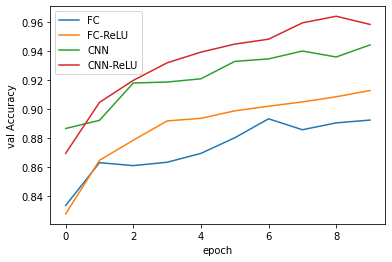

In [ ]:
sns.lineplot(x='epoch', y='val Accuracy', data=fc_results, label='FC')
sns.lineplot(x='epoch', y='val Accuracy', data=fc_relu_results, label='FC-ReLU')
sns.lineplot(x='epoch', y='val Accuracy', data=cnn_results, label='CNN')
sns.lineplot(x='epoch', y='val Accuracy', data=cnn_relu_results, label='CNN-ReLU')

You'll find that there are _many_ other flavors of the ReLU activation function, several of which are built into PyTorch. There is the `PReLU` that attempts to learn what $\alpha$ should be for the LeakyReLU, removing it as a hyper-parameter. `ReLU6` introduces an intentional saturation for the odd scenario where you actually want that kind of behavior. There are also "smooth" extensions to the ReLU like `CELU`, `CELU`, and `ELU` which have been derived to have certain properties. Those are just the ones already in PyTorch, you can find even more variants and alternatives to the ReLU online! We don't have time or space to go into all of these, but the improvement from $\tanh(\cdot)$ to ReLUs is not as big as the difference from ReLU and it's leaky variant to these other new flavors. If you want to learn more about these other activations functions they are worth trying, as we have seen it can make a big difference! But you'll generally be safe and in good company using any ReLU variants as your default choice. 

# Normalization Layers

The next tool we are going to learn about is called a _normalization layer_. Normalization layers are unique because they don't make a neural network any "stronger". If you had two networks _A_ and _B_, where the only difference between them was _A_ had normalization layers but _B_ does not, theoretically _A_ and _B_ are _equally capable_ of learning the _exact_ same thing. There is no function that _A_ could learn but _B_ could not, and vice versa. And yet, normalization layers have become frustratingly successful. In many ways they act like a kind of "magic pixie dust",  you sprinkle it into your neural network and suddenly it converges faster to better solutions than before! They even help networks that would not train well at all before suddenly become top contenders in terms of accuracy and results. So they are a valuable tool you will want to have in your toolbox of reusable components to add to your neural networks. 

In order to explain a normalization layer and how it works,  lets talk about how you might handle normalizing a normal dataset $\boldsymbol{X} = \{\boldsymbol{x}_1, \boldsymbol{x}_2, \ldots, \boldsymbol{x}_n \}$, that has $n$ rows and $d$ features. 
Before you start feeding in the matrix $\boldsymbol{X}$ into your favorite ML algorithm, you usually normalize or standardize the features in some way. This could be making sure that the values are all within the range of $[0, 1]$, or by subtracting the mean $\mu$ and dividing by the standard deviation $\sigma$ \footnote{Annoyingly, $\sigma$ is used for _both_ denoting standard deviation as well as the sigmoid activation function. You'll have to use context to make sure you differentiate them!}. Standardizing by removing the mean, and dividing by the standard deviation, is shown in the below three steps:

$$\boldsymbol{\mu} = \frac{1}{n}\sum_{1=1}^n \boldsymbol{x}_i$$

$$\boldsymbol{\sigma} = \sqrt{\epsilon + \frac{1}{n}\sum_{1=1}^n (\boldsymbol{\mu}-\boldsymbol{x}_i) \odot (\boldsymbol{\mu}-\boldsymbol{x}_i) }=  \sqrt{\epsilon +  \frac{1}{n}\sum_{1=1}^n (\boldsymbol{\mu}-\boldsymbol{x}_i)^2 }$$

$$\boldsymbol{\hat{X}} = \{\ldots, \frac{\boldsymbol{x}_i-\boldsymbol{\mu}}{\boldsymbol{\sigma}}, \ldots\}$$

We do this because most algorithms are sensitive to the _scale_ of the input data. This scale sensitivity means if you multiplied every feature in your dataset by $1,000$, it changes what your models end up learning.  By performing normalization or standardization, we make sure our data is in a reasonable numeric range (-1, to 1 is a good place to be), which makes it easier for our optimization algorithms to run. 

Before we train our neural networks, we again usually do normalization or standardization before passing the data into the first layer of our network. But what if we applied this normalization process before _every_ layer of a neural network? Would this allow the network to learn even faster? If you include a few extra details, it turns out that the answer is yes! 

Normalization layers usually take the form:

$$\frac{\boldsymbol{x}-\boldsymbol{\mu}}{\boldsymbol{\sigma}} \cdot \boldsymbol{\gamma} + \boldsymbol{\beta}$$

The first term is the same kind of term we had remove before, the mean is removed from the data, and then normalized by the standard deviation. The crucial addition here is the $\boldsymbol{\gamma}$ and $\boldsymbol{\beta}$ terms, which at learned parameters (so they will be included in the set of all parameters $\Theta$). It is common to initialized $\boldsymbol{\gamma} = \vec{1}$, and $\boldsymbol{\beta}=\vec{0}$, so that at the start each layer is doing a simple standardization. As training progresses, gradient descent allows us to scale (alter $\boldsymbol{\gamma}$) or shift (alter $\boldsymbol{\beta}$) the result as desired. 

This standard form has been used in a number of different ways, with details varying on what exactly we are normalizing over. Based on what we choose to normalize, approaches have different pros and cons. The interesting thing about normalization layers is they _do not increase the power of your network_. Any network without normalization could hypothetically learn any function just as well as a network with normalization. So why are we going to learn about these normalization layers? Because they have proven effective at helping improve the optimization process, allowing us to learn faster, and often to a better quality solution, than if we did not have them at all. Now that we understand what they are trying to do, we will talk about two of the most common forms of layer normalization. 

## Batch Normalization

The first, and most popular, type of normalization layer is called _Batch Normalization_ (BN). BN gets applied differently depending on the structure of the input data. If we are working with fully connected layers (PyTorch dimension would be $(B, D)$) we take the average of the feature values $D$ over the $B$ items in the batch. Hence, we _normalize_ over the data features in a a given _batch_. This means that $\boldsymbol{\mu}$, $\boldsymbol{\sigma}$, $\boldsymbol{\gamma}$ and $\boldsymbol{\beta}$ will have a shape of $(D)$, and each item in the batch is normalized by the mean and standard deviation _of just that batch of data_. 

To make this clear, lets look at some hypothetical python code that would compute $\boldsymbol{\mu}$ and  $\boldsymbol{\sigma}$ based on a tensor with shape $(B, D)$. We will make the `for` loops explicit to make it clear. If you were to implement this for real use, you should try and use functions like `torch.sum` or `torch.mean` to make this run fast. 

```python
#BN example with explicit loops, you wouldn't write torch code like this for real!
B, D = X.shape #So X  is of shape (B, D) for this example
𝝁 = torch.zeros((D))
𝝈 = torch.zeros((D))
for i in range(B):
    𝝁 += X[i,:]
𝝁 /= B
for i in range(B):
    𝝈 += (X[i,:]-𝝁)*(X[i,:]-𝝁)
𝝈 += 1e-5
𝝈 = torch.sqrt(𝝈)
```

Because of this, BN is very sensitive to the batch size during training, and is impossible to use when you have a batch size of 1. It also takes some cleverness to use at inference/prediction time, because you don't want your predictions to depend on the other data being available! To resolve this, most implementations keep a running estimate of the mean and standard deviation across all previously seen batches, and use that single estimate for all predictions once training is done. 

What about if we have 1-D data, of shape $(B, C, D)$? In this case, we normalize the _channels_ over the batch. This means that  $\boldsymbol{\mu}$, $\boldsymbol{\sigma}$, $\boldsymbol{\gamma}$ and $\boldsymbol{\beta}$ will now each have a shape of $(C)$. This is because we want to treat each of the $D$ values in a channel as having the same nature and structure, so the average is over the $B \times D$ values in the channel across all $B$ batches. We then apply the same scale $\boldsymbol{\gamma}$, and shit $\boldsymbol{\beta}$, to all the values in each channel. If we have 2-D data of shape $(B, C, W, H)$? Similar to the 1-D case, $\boldsymbol{\mu}$, $\boldsymbol{\sigma}$, $\boldsymbol{\gamma}$ and $\boldsymbol{\beta}$ have a shape of $(C)$. For any $z$-Dimensional structured data where we have channels, we always use Batch Norm over the Channels. The below table summarizes which PyTorch module you should be looking for depending on the tensor shape. 

| Tensor Shape | PyTorch Module   |
|---------|------|
|   $(B, D)$  | `torch.nn.BatchNorm1d(D)` |
|   $(B, C, D)$  | `torch.nn.BatchNorm1d(C)` |
|   $(B, C, W, H)$  | `torch.nn.BatchNorm2d(C)` |
|   $(B, C, W, H, D)$  | `torch.nn.BatchNorm3d(C)` |

So if we were to apply Batch Normalization to an input tensor $X$ at inference time, it might look something like this in code:

```python
BN = torch.tensor((B, C, W, H))
for j in range(C):
    BN[:,j,:,:] = (X[:,j,:,:]-𝝁[j])/𝝈[j] *𝜸[j] + 𝜷[j]
```

When we created our data loaders for FashionMNIST we used a batch size of 128, so we should have no issue applying BN to our architectures. Following the above table, we will add `BatchNorm1d` after each `nn.Linear` layer of our fully-connected network, and `nn.BatchNorm2d` after each `nn.Conv2d` layer of our CNN. The below blocks of code again re-define both networks with our new addition, and train them up on the same dataset. 

In [ ]:
fc_bn_model = nn.Sequential(
    Flatten(),
    nn.Linear(D,  n),
    nn.BatchNorm1d(n),
    nn.LeakyReLU(leak_rate),
    nn.Linear(n,  n),
    nn.BatchNorm1d(n),
    nn.LeakyReLU(leak_rate),
    nn.Linear(n,  n),
    nn.BatchNorm1d(n),
    nn.LeakyReLU(leak_rate),
    nn.Linear(n,  n),
    nn.BatchNorm1d(n),
    nn.LeakyReLU(leak_rate),
    nn.Linear(n,  n),
    nn.BatchNorm1d(n),
    nn.LeakyReLU(leak_rate),
    nn.Linear(n,  n),
    nn.BatchNorm1d(n),
    nn.LeakyReLU(leak_rate),
    nn.Linear(n, classes),
)


In [ ]:
fc_bn_results = train_network(fc_bn_model, loss_func, train_loader, val_loader=test_loader, epochs=10, score_funcs={'Accuracy': accuracy_score}, device=device)
del fc_bn_model

In [ ]:
cnn_bn_model = nn.Sequential(
    nn.Conv2d(C, n_filters, (3,3), padding=1), 
    nn.BatchNorm2d(n_filters),
    nn.LeakyReLU(leak_rate),
    nn.Conv2d(n_filters, n_filters, (3,3), padding=1), 
    nn.BatchNorm2d(n_filters),
    nn.LeakyReLU(leak_rate),
    nn.Conv2d(n_filters, n_filters, (3,3), padding=1), 
    nn.BatchNorm2d(n_filters),
    nn.MaxPool2d((2,2)),
    nn.LeakyReLU(leak_rate),
    nn.Conv2d(n_filters, 2*n_filters, (3,3), padding=1),
    nn.BatchNorm2d(2*n_filters), 
    nn.LeakyReLU(leak_rate),
    nn.Conv2d(2*n_filters, 2*n_filters, (3,3), padding=1), 
    nn.BatchNorm2d(2*n_filters),
    nn.LeakyReLU(leak_rate),
    nn.Conv2d(2*n_filters, 2*n_filters, (3,3), padding=1), 
    nn.MaxPool2d((2,2)),
    nn.BatchNorm2d(2*n_filters),
    nn.LeakyReLU(leak_rate),
    nn.Conv2d(2*n_filters, 4*n_filters, (3,3), padding=1), 
    nn.BatchNorm2d(4*n_filters),
    nn.LeakyReLU(leak_rate),
    nn.Conv2d(4*n_filters, 4*n_filters, (3,3), padding=1), 
    nn.BatchNorm2d(4*n_filters),
    nn.LeakyReLU(leak_rate),
    Flatten(),
    nn.Linear(D*n_filters//4, classes),
)

In [ ]:
cnn_bn_results = train_network(cnn_bn_model, loss_func, train_loader, val_loader=test_loader, epochs=10, score_funcs={'Accuracy': accuracy_score}, device=device)
del cnn_bn_model

The results of our new network are shown below, plotted against our previous best result from adding the ReLU activation. Again we see an improvement in accuracy across the board, _especially_ for our CNN! 

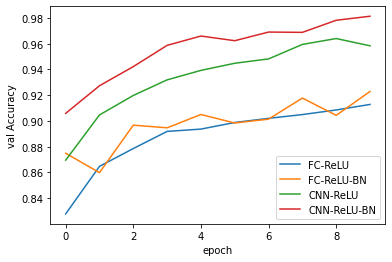

In [ ]:
sns.lineplot(x='epoch', y='val Accuracy', data=fc_relu_results, label='FC-ReLU')
sns.lineplot(x='epoch', y='val Accuracy', data=fc_bn_results, label='FC-ReLU-BN')
sns.lineplot(x='epoch', y='val Accuracy', data=cnn_relu_results, label='CNN-ReLU')
sns.lineplot(x='epoch', y='val Accuracy', data=cnn_bn_results, label='CNN-ReLU-BN')

Why does this work so well? The best intuition I can give you is the logic we walked through above, that normalizing helps to ensure our literal numeric values after each layer are in a generically "good" range, and through $\gamma$ and $\beta$ the network can _decide_ where precisely that range is. Getting to the root of _why_ this works though is actually an active research area in deep learning! So unfortunately no one has a truly definitive answer yet. 

\title{Proof that Batch-Norm does not add representational power}It may seem odd that I saw that normalization layers do not add any representational power to the network. We've added a new kind of layer, and adding more layers does generally make a network capable of representing more complex functions. So why are normalization layers different? 

We can answer that with just a little bit of algebra! Remember that we said normalization layers take. the form of $\frac{\boldsymbol{x}-\boldsymbol{\mu}}{\boldsymbol{\sigma}} \cdot \boldsymbol{\gamma} + \boldsymbol{\beta}$. But that $x$ value is the result from a linear layer. So we can re-write this as 

$$\frac{(\boldsymbol{x}^\top W + \boldsymbol{b})-\boldsymbol{\mu}}{\boldsymbol{\sigma}} \cdot \boldsymbol{\gamma} + \boldsymbol{\beta}$$

Using algebra we can take the following steps to simplify this through the following steps:

First, the order of operations in the numerator don't change with or without the parenthesis, so lets remove them. 
$$\frac{\boldsymbol{x}^\top W + \boldsymbol{b}-\boldsymbol{\mu}}{\boldsymbol{\sigma}} \cdot \boldsymbol{\gamma} + \boldsymbol{\beta}$$

Now lets move $\boldsymbol{\gamma}$ to the left and apply it to the terms in the numerator. We'll group the two shifts of the bias term $\boldsymbol{b}$ and the mean $\boldsymbol{\mu}$ together. 
$$\frac{\boldsymbol{x}^\top W \cdot \boldsymbol{\gamma} + (\boldsymbol{b}-\boldsymbol{\mu})\cdot \boldsymbol{\gamma}}{\boldsymbol{\sigma}}  + \boldsymbol{\beta}$$

Now lets apply the division by $\boldsymbol{\sigma}$ to each term independently. 
$$\frac{\boldsymbol{x}^\top W \cdot \boldsymbol{\gamma}}{\boldsymbol{\sigma}} + \frac{(\boldsymbol{b}-\boldsymbol{\mu})\cdot \boldsymbol{\gamma}}{\boldsymbol{\sigma}}  + \boldsymbol{\beta}$$

The left most term involves the vector matrix product of $\boldsymbol{x}^\top W$, so we can move all the element wise operations with $\boldsymbol{\gamma}$ and $\boldsymbol{\sigma}$ onto just $W$ and make $\boldsymbol{x}$ something that happens after, the result is the same. 

$$\boldsymbol{x}^\top \left(\frac{W \cdot \boldsymbol{\gamma}}{\boldsymbol{\sigma}}\right) + \frac{(\boldsymbol{b}-\boldsymbol{\mu})\cdot \boldsymbol{\gamma}}{\boldsymbol{\sigma}}  + \boldsymbol{\beta}$$

Now do you see the answer in sight? We have the same situation we talked about in chapter two and three. Normalization is a _linear operation_ and _any consecutive sequence of linear operations is equivalent to one linear operation!_ The sequence of linear layers followed by BN is _equivalent_ do a different, single `nn.Linear` layer with weights $\tilde{W}$ + and biases $\tilde{\boldsymbol{b}}$. 

$$\boldsymbol{x}^\top \underbrace{\left(\frac{W \cdot \boldsymbol{\gamma}}{\boldsymbol{\sigma}}\right)}_{\tilde{W}} + \underbrace{\frac{(\boldsymbol{b}-\boldsymbol{\mu})\cdot \boldsymbol{\gamma}}{\boldsymbol{\sigma}}  + \boldsymbol{\beta}}_{\tilde{\boldsymbol{b}}} = \boldsymbol{x}^\top \tilde{W} + \tilde{\boldsymbol{b}} $$

If you use convolutional layers you get the same kind of result. This has caused some deep learning researchers and even practitioners some consternation that BN is so effective, but it's utility is so enormous it's had to turn down. 

## Layer Normalization

Another popular type of normalization approach is (confusingly) called _Layer Norm_ (LN), where we look at the average activation _over features_ instead of over batches. This means every example within a batch will get its own $\mu$, and $\sigma$, values, but share a single $\boldsymbol{\gamma}$ and $\boldsymbol{\beta}$ that are learned. Again, we can look at an example with explicit code to make this clear:

```python
#LN example with explicit for loops, again, don't actually write code like this!
B, D = X.shape #So X  is of shape (B, D) for this example
𝝁 = torch.zeros((B))
𝝈 = torch.zeros((B))
for j in range(D):
    𝝁 += X[:, j] #Notice this changed from X[i,:] before! 
𝝁 /= D
for j in range(D):
    𝝈 += (X[:,j]-𝝁)*(X[:,j]-𝝁)#Again, changed from X[i,:]!
𝝈 += 1e-5
𝝈 = torch.sqrt(𝝈)
```

The only difference between LN and BN is thus _what_ we are averaging over! With Layer Norm, it does not matter how many examples are present in a batch $B$, so we can use LN when batches are smaller. 

With that we can dive into our repeated example of applying this new method to our same network architecture. Unlike BN which has a different class in PyTorch for each kind of tensor shape you may want to use, LN has one class for _all_ architectures. There are some nuanced reasons for this that relate to certain kinds of problems where LN is preferred, over BN that also require some extra flexibility. 

The `nn.LayerNorm` class takes in a single argument that is a _list_ of integers. If you are working on a fully connected layers with tensors of shape $(B, D)$ then you would use `nn.LayerNorm([D])` as the input. Below you can see the code four our fully-connected network that uses LN. 

In [ ]:
fc_ln_model = nn.Sequential(
    Flatten(),
    nn.Linear(D,  n),
    nn.LayerNorm([n]),
    nn.LeakyReLU(leak_rate),
    nn.Linear(n,  n),
    nn.LayerNorm([n]),
    nn.LeakyReLU(leak_rate),
    nn.Linear(n,  n),
    nn.LayerNorm([n]),
    nn.LeakyReLU(leak_rate),
    nn.Linear(n,  n),
    nn.LayerNorm([n]),
    nn.LeakyReLU(leak_rate),
    nn.Linear(n,  n),
    nn.LayerNorm([n]),
    nn.LeakyReLU(leak_rate),
    nn.Linear(n,  n),
    nn.LayerNorm([n]),
    nn.LeakyReLU(leak_rate),
    nn.Linear(n, classes),
)

In [ ]:
fc_ln_results = train_network(fc_ln_model, loss_func, train_loader, val_loader=test_loader, epochs=10, score_funcs={'Accuracy': accuracy_score}, device=device)
del fc_ln_model

This list is because you are telling LN, from right to left, which values to average over. So if we have a 2D problem with tensors of shape $(B, C, W, H)$ we are going to give LN the last three dimensions as that covers _all the features_. This means we also need to pay attention to how large the width and height is, which will change every time we apply max-pooling. You can see that in the below code. 

This is also _another_ reason why we use padding with our convolutional layers! By padding the convolution so that the output has the same width and height as the input, we simply the things we need to keep track of. Right now we need to divide by 2 for each round of pooling. The code would be _far_ more complicated if we also had to keep track of how many times we did convolutions. That would also make it much harder to make changes to our network's definition!

In [ ]:
cnn_ln_model = nn.Sequential(
    nn.Conv2d(C, n_filters, (3,3), padding=1), 
    nn.LayerNorm([n_filters, W, H]),#three values for the ending three dimensions, that are set to their size
    nn.LeakyReLU(leak_rate),
    nn.Conv2d(n_filters, n_filters, (3,3), padding=1), 
    nn.LayerNorm([n_filters, W, H]),
    nn.LeakyReLU(leak_rate),
    nn.Conv2d(n_filters, n_filters, (3,3), padding=1), 
    nn.LayerNorm([n_filters, W, H]),
    nn.MaxPool2d((2,2)), #This just shrank W and H by 2!
    nn.LeakyReLU(leak_rate),
    nn.Conv2d(n_filters, 2*n_filters, (3,3), padding=1),#this increased the channels by a factor of 2!
    nn.LayerNorm([2*n_filters, W//2, H//2]),  #So next LN we have to account for both of these changes
    nn.LeakyReLU(leak_rate),
    nn.Conv2d(2*n_filters, 2*n_filters, (3,3), padding=1), 
    nn.LayerNorm([2*n_filters, W//2, H//2]),
    nn.LeakyReLU(leak_rate),
    nn.Conv2d(2*n_filters, 2*n_filters, (3,3), padding=1), 
    nn.MaxPool2d((2,2)),
    nn.LayerNorm([2*n_filters, W//4, H//4]), #Again LN shapes changed, can you tell which preceding layer caused it?
    nn.LeakyReLU(leak_rate),
    nn.Conv2d(2*n_filters, 4*n_filters, (3,3), padding=1), 
    nn.LayerNorm([4*n_filters, W//4, H//4]),
    nn.LeakyReLU(leak_rate),
    nn.Conv2d(4*n_filters, 4*n_filters, (3,3), padding=1), 
    nn.LayerNorm([4*n_filters, W//4, H//4]),
    nn.LeakyReLU(leak_rate),
    Flatten(),
    nn.Linear(D*n_filters//4, classes),
)

In [ ]:
cnn_ln_results = train_network(cnn_ln_model, loss_func, train_loader, val_loader=test_loader, epochs=10, score_funcs={'Accuracy': accuracy_score}, device=device)
del cnn_ln_model

Below are the results with LN. The "magic pixie dust" powers don't appear to be as strong. For the CNN LN is an improvement over _no_ normalization, but worse than BN. For the fully-connected layers LN appears to be more inline with the non-normalized variant. 

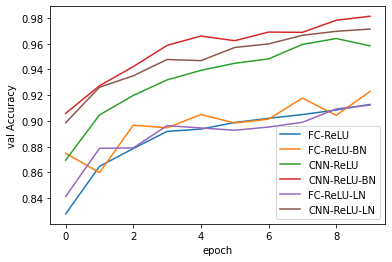

In [ ]:
sns.lineplot(x='epoch', y='val Accuracy', data=fc_relu_results, label='FC-ReLU')
sns.lineplot(x='epoch', y='val Accuracy', data=fc_bn_results, label='FC-ReLU-BN')
sns.lineplot(x='epoch', y='val Accuracy', data=cnn_relu_results, label='CNN-ReLU')
sns.lineplot(x='epoch', y='val Accuracy', data=cnn_bn_results, label='CNN-ReLU-BN')
sns.lineplot(x='epoch', y='val Accuracy', data=fc_ln_results, label='FC-ReLU-LN')
sns.lineplot(x='epoch', y='val Accuracy', data=cnn_ln_results, label='CNN-ReLU-LN')

## Which Normalization Layer To Use?

While normalization layers have been around for a few years now, fully understanding them and when to use this is an active research problem. For non-recurrent networks, Batch Normalization is a good idea to use _provided_ you can train on batches $B \geq 64$. If your batch isn't big enough, you won't get a good estimate of $\mu$ and $\sigma$ and your results could suffer for it! If your problem fits this situation of larger batches, BN will _usually_ improve your results, but there are some peculiar instances where it does not! So if you find you are having difficulty getting your model to train, its worth testing a version of your model without Batch Norm to see if you are in the odd situation where BN _hurts_ instead of helping. 

Layer Normalization has been particularly popular for recurrent architectures and is worth adding to your RNN. LN should be your first pick whenever you are re-using a sub-network with weight sharing, because BN's statistics assume _one_ distribution and when you do weight sharing you get _multiple_ distributions, which can cause problems. Layer Norm can also be effective when you have small batch sizes $B \leq 32$, though does not usually provide the same level of improvement as Batch Norm for CNNs and fully-connected networks. This can be a factor when making your network larger looks like it will improve performance, but you can't make it any larger without having to shrink the batch size due to a lack of RAM. 

While Batch and Layer Norm are the two most popular and widely used normalization layers, they are far from the only ones being developed and used! Its worth keeping your eye out for new approaches to normalization layers, and is often an easy change to make to your code. 

# Skip Connections

Now that we have learned about some new `Module`s that improve our networks, lets turn to learning about some new _designs_ that we can incorporate into our networks. The first of which is called a _skip-connection_. With a normal network, an output from one layer goes directly to the next layer. With skip connections this is still true, but we also "skip" the next layer and connect to a preceding layer as well! There are _many_ ways to do this, and the image below shows a few options. 

![The left most diagram shows a normal feed-forward design. The right two diagrams show two different ways you can implement skip-connections. The black dots on the connections indicate concatenation of the outputs from all of the inputs. ](https://drive.google.com/uc?export=view&id=18jttmWLympm1w8mXb-aKMaKVJN9c8v4F)


The left image is a normal network that we have been using. The second shows one strategy of having every other layer "skip" to the next one. When this happens, the number of inputs to ever 2nd layer increases based on the size of the outputs from the two preceding layers inputs. The idea is that every solid dot in the digram indicates a concatenation of outputs! So if we have $\boldsymbol{x}$ and $\boldsymbol{h}$ connect in the diagram, they input to the next layer would be $[\boldsymbol{x}, \boldsymbol{h}]$. In code this would be something like `torch.cat([x, h], dim=1)`. That way the two inputs $\boldsymbol{x}$ and $\boldsymbol{h}$ have shapes $(B, D)$ and $(B, h)$, we want to stack the features together so the result will have shape $(B, D+H)$. 
The third example on the right shows having multiple inputs skip to one specific layer, giving it three times as many inputs! This will cause the final layer's input size to triple based on the three layers coming into it all having an output size of $h$. 

So why would we use skip connections? Part of the intuition is that they skip-connections the optimization process easier. Consider the normal network example on the left. The gradient contains the information we need to learn and adjust every parameter. On the left side, the first hidden layer requires waiting for three other layers to  process and pass along a gradient before obtaining any information. But every step is also an opportunity for noise, and if we had too many layers learning would become ineffective. 

Now lets think about it from the case of the right hand side. Every hidden layer gets some amount of information of the gradient directly from the output layer, giving literally more direct access to the gradient, as well as the gradient processed from the longer path going layer by layer! This more direct feedback can make the learning easier. By "skipping" the intermediate layers and connecting directly to the output, the earlier layers get a "fresher" gradient that has less opportunities for noise, and hopefully thus improves learning. 

However, having every layer connect directly to the output can be overkill, and eventually make the learning problem harder! Imagine if you had 100 hidden layers all connected directly to the output layer, that would be a _huge_ input for the output layer to try and deal with! The option in the middle represents a good compromise. A shorter path exists through the entire network, reducing the number of intermediate layers in between a node and the gradient source by half. 

Now that we've talked about skip connections, lets try implementing some! The below code shows how to create the 2nd style of skip connection, where a large number of layers are going to skip to one final layer. Then we can re-use this layer multiple times to create a hybrid strategy of short cuts every other layer!

In [ ]:
class SkipFC(nn.Module):
    def __init__(self, n_layers, in_size, out_size, leak_rate=0.1):
        super().__init__()
        
        l = n_layers-1
        
        self.layers = nn.ModuleList([nn.Linear(in_size*l, out_size) if i == l else nn.Linear(in_size, in_size)
                                     for i in range(n_layers)])
        self.bns = nn.ModuleList([nn.BatchNorm1d(out_size) if i == l else nn.BatchNorm1d(in_size)
                                     for i in range(n_layers)])
        
        self.activation = nn.LeakyReLU(leak_rate)
    
    def forward(self, x):
        
        activations = []
        
        for layer, bn in zip(self.layers[:-1], self.bns[:-1]):
            x = self.activation(bn(layer(x)))
            activations.append( x )
        x = torch.cat(activations, dim=1)
        
        x = self.activation(self.bns[-1](self.layers[-1](x)))
        
        return x

In [ ]:
fc_skip_model = nn.Sequential(
    Flatten(),
    SkipFC(2, D, n),
    SkipFC(2, n, n),
    SkipFC(2, n, n),
    nn.Linear(n, classes),
)

In [ ]:
fc_skip_results = train_network(fc_skip_model, loss_func, train_loader, val_loader=test_loader, epochs=10,
                                 score_funcs={'Accuracy': accuracy_score}, device=device)


In [ ]:
del fc_skip_model

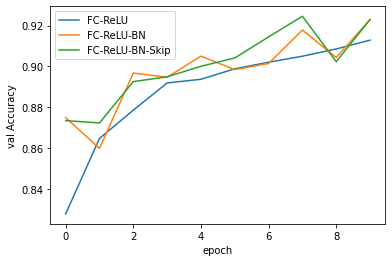

In [ ]:
sns.lineplot(x='epoch', y='val Accuracy', data=fc_relu_results, label='FC-ReLU')
sns.lineplot(x='epoch', y='val Accuracy', data=fc_bn_results, label='FC-ReLU-BN')
sns.lineplot(x='epoch', y='val Accuracy', data=fc_skip_results, label='FC-ReLU-BN-Skip')

So those results were kind of inconclusive. You should see that sometimes the skip connections do better, and sometimes worse, if you run the code multiple times. What about a convolutional network? Maybe CNNs are more effective there! 

In [ ]:
class SkipConv2d(nn.Module):
    def __init__(self, n_layers, in_channels, out_channels, kernel_zie=3, leak_rate=0.1):
        super().__init__()
        
        l = n_layers-1
        f = (kernel_zie, kernel_zie)
        pad = (kernel_zie-1)//2
        
        self.layers = nn.ModuleList([nn.Conv2d(in_channels*l, out_channels, kernel_size=f, padding=pad) if i == l else nn.Conv2d(in_channels, in_channels, kernel_size=f, padding=pad)
                                     for i in range(n_layers)])
        self.bns = nn.ModuleList([nn.BatchNorm2d(out_channels) if i == l else nn.BatchNorm2d(in_channels)
                                     for i in range(n_layers)])
        
        self.activation = nn.LeakyReLU(leak_rate)
    
    def forward(self, x):
        
        activations = []
        
        for layer, bn in zip(self.layers[:-1], self.bns[:-1]):
            x = self.activation(bn(layer(x)))
            activations.append( x )
        x = torch.cat(activations, dim=1)
        
        x = self.activation(self.bns[-1](self.layers[-1](x)))
        
        return x

In [ ]:
cnn_skip_model = nn.Sequential(
    nn.Conv2d(C, n_filters, (3,3), padding=1), 
    SkipConv2d(3, n_filters, n_filters),
    nn.MaxPool2d((2,2)),
    nn.LeakyReLU(),
    SkipConv2d(3, n_filters, 2*n_filters),
    nn.MaxPool2d((2,2)),
    SkipConv2d(3, 2*n_filters, 4*n_filters),
    Flatten(),
    nn.Linear(D*n_filters//4, classes),
)

In [ ]:
cnn_skip_results = train_network(cnn_skip_model, loss_func, train_loader, val_loader=test_loader, epochs=10,
                                 score_funcs={'Accuracy': accuracy_score}, device=device)

In [ ]:
del cnn_skip_model

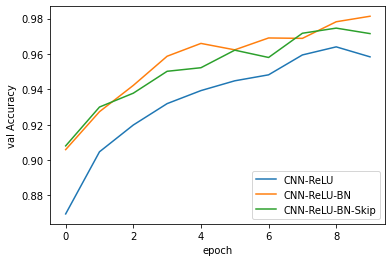

In [ ]:
sns.lineplot(x='epoch', y='val Accuracy', data=cnn_relu_results, label='CNN-ReLU')
sns.lineplot(x='epoch', y='val Accuracy', data=cnn_bn_results, label='CNN-ReLU-BN')
sns.lineplot(x='epoch', y='val Accuracy', data=cnn_skip_results, label='CNN-ReLU-BN-Skip')

Again, the results are fairly inconclusive! In practical experience, skip connections can sometimes make a big difference on their own, but its very problem dependent. So why are we learning about them? Combined with one more trick, skip-connections form one of the basic building blocks of a more powerful and routinely successful technique called a Residual Layer! 

# 1x1 Convolutions

Everything we have done with convolutions thus far has been to capture _spatial_ information, and we have talked about the point of convolutions is to capture this spatial _prior_ that values near each other (spatially) are related to each other. As such, our convolutions have a kernel with some size $k$, so that we can capture information about our $\lfloor k/2 \rfloor$ neighbors. 

But what if we set $k=1$? This would give us _no_ information about our neighbors, and thus captures _no spatial information_. At first glance, this would make a convolution like this to be a useless operation. However, there can be valuable reasons to use a convolution with this kind of neighbor blindness! 

This is possible because we have $C_{in}$ input channels and $C_{out}$ output channels when we perform a convolution. So a convolution with $k=1$ is looking not at spatial neighbors, but spatial _channels_ , by grabbing a stack of $C_{in}$ values and processing them all together at once. In essence we are giving the network a new prior, that it should try and and share information across channels, rather than looking at neighboring locations. Another way to think about this is that if each channel has learned to look for a different kind of pattern, we are telling the network to _focus on the patterns found at this location_ instead of having it try to build new spatial patterns.

For example, say we are processing an image and one channel has learned to identify edges that are horizontal, another channel vertical edges, another edges at a 45 degree angle, and so on. If we want a channel to learn to simply identify _any_ edge, we could accomplish that by looking just at the channel values (i.e., have _any_ of these angle-dependent edge detecting filters fired?) without considering the neighboring pixels. If such identifications are useful, $k=1$ convolutions can help improve learning and reduce computational cost! 

Such convolutions are easy to implement. We will do that by adding them below. As a way to help make our code shorter, we are also going to implement a helper function so we can do this without making our network definition ridiculously long! For a simple case of performing "information sharing", we will define a `infoShareBlock` function that takes in the number of input filters, and applies a $1\times 1$ convolution to maintain the size of the output, but hopefully perform some useful learning along the way. The below code does this by having the function build a small `nn.Sequential` object that we will then insert into our larger network definition, after which we can train as normal! 

In [ ]:
def infoShareBlock(n_filters):
    return nn.Sequential(
        nn.Conv2d(n_filters, n_filters, (1,1), padding=0), 
        nn.BatchNorm2d(n_filters),
        nn.LeakyReLU())

cnn_1x1_model = nn.Sequential(
    nn.Conv2d(C, n_filters, (3,3), padding=1), 
    nn.BatchNorm2d(n_filters),
    nn.LeakyReLU(leak_rate),
    nn.Conv2d(n_filters, n_filters, (3,3), padding=1), 
    nn.BatchNorm2d(n_filters),
    nn.LeakyReLU(leak_rate),
    infoShareBlock(n_filters),
    nn.Conv2d(n_filters, n_filters, (3,3), padding=1), 
    nn.BatchNorm2d(n_filters),
    nn.MaxPool2d((2,2)),
    nn.LeakyReLU(leak_rate),
    nn.Conv2d(n_filters, 2*n_filters, (3,3), padding=1),
    nn.BatchNorm2d(2*n_filters), 
    nn.LeakyReLU(leak_rate),
    infoShareBlock(2*n_filters),
    nn.Conv2d(2*n_filters, 2*n_filters, (3,3), padding=1), 
    nn.BatchNorm2d(2*n_filters),
    nn.LeakyReLU(leak_rate),
    nn.Conv2d(2*n_filters, 2*n_filters, (3,3), padding=1), 
    nn.MaxPool2d((2,2)),
    nn.BatchNorm2d(2*n_filters),
    nn.LeakyReLU(leak_rate),
    infoShareBlock(2*n_filters),
    nn.Conv2d(2*n_filters, 4*n_filters, (3,3), padding=1), 
    nn.BatchNorm2d(4*n_filters),
    nn.LeakyReLU(leak_rate),
    nn.Conv2d(4*n_filters, 4*n_filters, (3,3), padding=1), 
    nn.BatchNorm2d(4*n_filters),
    nn.LeakyReLU(leak_rate),
    infoShareBlock(4*n_filters),
    Flatten(),
    nn.Linear(D*n_filters//4, classes),
)

In [ ]:
cnn_1x1_results = train_network(cnn_1x1_model, loss_func, train_loader, val_loader=test_loader, epochs=10, score_funcs={'Accuracy': accuracy_score}, device=device)
del cnn_1x1_model

If you look below when we plot the results, you should see that we actually did not seem to improve our accuracy much. Why is that? Well, the example we gave above about information sharing _can be done by larger filters anyway_. So this process has not necessarily allowed us to learn something we could not learn before. 

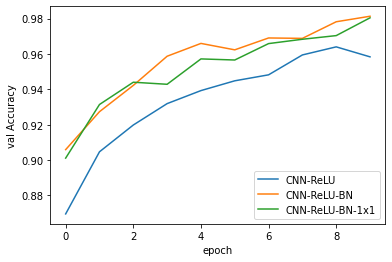

In [ ]:
sns.lineplot(x='epoch', y='val Accuracy', data=cnn_relu_results, label='CNN-ReLU')
sns.lineplot(x='epoch', y='val Accuracy', data=cnn_bn_results, label='CNN-ReLU-BN')
sns.lineplot(x='epoch', y='val Accuracy', data=cnn_1x1_results, label='CNN-ReLU-BN-1x1')

While $1\times1$ convolutions still have the benefit of being cheaper to run, we can't just throw them around and get better results. It turns out they are a fairly specialized tool and it takes a mix of experience and intuition to learn when they are worth adding to your model. 

# Residual Connections

Now we have learned about two approachs that, on their own, don't seem to be all that useful. Sometimes they do better, sometimes worse. But if we combine skip-connections and 1x1 convolutions in just the right way, we get an approach called a _residual connection_, that works much better! This residual connection is actually broken up into two types of connections. 

The first connection type is a _residual block_, which can be found in the below diagram. The block is a kind of skip-connection were two layers will combine at the end, creating a long and short path. However, in a  residual block the short path has _no operations_. We simply leave the input unaltered! Then once the long path has computed it's result $\boldsymbol{h}$, we add it to the input $\boldsymbol{x}$ to get the final result $\boldsymbol{x+h}$. 

![Example of a residual block architecture. The left side of the block is the "residual" path, which performs no operations or alterations to the input. The right side of the block performs a skip connection with two rounds of BatchNorm/Linear/activation to produce an intermediate results $\boldsymbol{h}$. The output is the addition of the input $\boldsymbol{x}$ and $\boldsymbol{h}$.  ](https://drive.google.com/uc?export=view&id=1pWDhG8TkVIewEPDZyhUEcDKDPbPpuXio)


When we start combining multiple residual bocks one after another, we end up creating an architecture with a very interesting design. You can see that in the below figure were we end up with a _long_ and _short_ path through the network. The short path makes it easier to learn deep architectures by having as few operations as possible. Less operations means less chance of noise in the gradient, making it easy to propagate a useful gradient back farther than would otherwise be possible. The long path then performs the actual work, learning units of complexity that are added back in via the skip connections (using addition instead of concatenation). 

![An architecture with multiple layers of residual blocks. This creates a long and short path through the network. The short path on top makes it easy to get the gradient to propagate back to many layers, allowing for more depth by avoiding as much work as possible. The long path does the actual work, allowing the network to learn complex functions one piece at a time. ](https://drive.google.com/uc?export=view&id=1eisMddsJigTZfKAahJZssDANa5o7_yBM)



This kind of residual block can be easily converted to a fully-connected counterpart. But when we are working with images, we like to do a few rounds of max pooling to help build some translation invariance, and then double the number of channels after each round of pooling to maintain a consistent amount of computation and work done at each layer of the network. But the residual block _requires_ that the input and output have the same shape, so if we ever change the number of channels we won't be able to make the skip connection. 

The solution to this problem is our $1\times1$ convolutions! We can use the $1\times1$ layer to do the minimum amount of work to simply chance the number of channels in the input, increasing or decreasing the number of channels as we see fit. The preferred approach is to create a _residual bottleneck_ whenever we want to do this, which is shown in the below figure. 

![Example of a bottle neck connection where the input has $(B, C, W, H)$ as its input shape, and the goal is to have an output shape of $(B, C', W, H)$. The short path has to change shape, so a $1\times1$ convolution is used to do the minimum work needed to change the number of channels. The long path is supposed to be a "bottle neck" that encourages compression, so it starts with a $1\times1$ to shrink the number of channels, followed by a normal convolution, and ending with another $1\times1$ to expand the number of channels back up to the desired size $C'$. ](https://drive.google.com/uc?export=view&id=109XkSgiYEkY5eL0dpivQ6mC82yrD1DZv)



Now we have the tools for convolutional residual blocks that increase or decrease the number of channels. If we want to use a bottle neck layer but not change the number of channels, we can simply replace the short path with "nothing" like we had in the original residual block. 

The residual connections have been extraordinarily successful, giving bigger advantages for harder problems. Since our problem is simple, we  won't see as much benefit - but it will still give us some improvement. The below code implements both types of residual layers for us to use. The residual block we have described in particular is called "Type E" and is one of the favored residual setups. As you might have guessed from a name like "Type E" people have tried _tons_ of different re-orderings on the normalization, convolution, and number of layers within each residual block. Most of them tend to work well, but well stick with the Type E one for simplicity. 

In [ ]:
class ResidualBlockE(nn.Module):
    def __init__(self, channels, kernel_size=3, leak_rate=0.1):
        super().__init__()
        #how much padding will our convolutional layers need to maintain the input shape
        pad = (kernel_size-1)//2
        
        #Define the conv an BN layers we will use
        self.conv1 = nn.Conv2d(channels, channels, kernel_size, padding=pad)
        self.bn1   = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size, padding=pad)
        self.bn2   = nn.BatchNorm2d(channels)
        #We need to pick an activation function. You can easily change this to try a different one!
        self.activation = nn.LeakyReLU(leak_rate)
     
    def forward(self, x):
        residual = x#save x as the residual value
        #apply the long path work
        x = self.conv1(self.activation(self.bn1(x)))
        x = self.conv2(self.activation(self.bn2(x)))
        #add the residual back in!
        x = x + residual
        return x
    
class ResidualBottleNeck(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, leak_rate=0.1):
        super().__init__()
        #how much padding will our convolutional layers need to maintain the input shape
        pad = (kernel_size-1)//2
        #The botteneck should be smaller, so output/5 or input. You could try changing max to min
        bottleneck = max(out_channels//4, in_channels)
        #Define the three sets of BN and convolution layers we need. 
        #Notice that for the 1x1 convs we use padding=0, because 1x1 will not change shape! 
        self.bn1   = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(in_channels, bottleneck, 1, padding=0)
        
        self.bn2   = nn.BatchNorm2d(bottleneck)
        self.conv2 = nn.Conv2d(bottleneck, bottleneck, kernel_size, padding=pad)
        
        self.bn3   = nn.BatchNorm2d(bottleneck)
        self.conv3 = nn.Conv2d(bottleneck, out_channels, 1, padding=0)
        
        self.activation = nn.LeakyReLU(leak_rate)
        #By default, our shortcut will be the identiy function - which simply returns the input as the output
        self.shortcut = nn.Identity()
        #If we need to change the shape, then lets turn the shortcut into a small layer with 1x1 conv and BM
        if in_channels != out_channels:
            self.shortcut =  nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, 1, padding=0), 
                    nn.BatchNorm2d(out_channels)
                )
    
    def forward(self, x):
        residual = x#save the residual!
        #apply the long path
        x = self.conv1(self.activation(self.bn1(x)))
        x = self.conv2(self.activation(self.bn2(x)))
        x = self.conv3(self.activation(self.bn3(x)))
        #add the shortcut of the residual back in
        x = self.shortcut(residual) + x
        return x

Now we can define a residual network! It is difficult to make this the exact same as our original network because each Residual layer has 2-3 rounds of layers in it as well. But the below definition gets us to something close and reasonable. We did not have to, but since our network is on the small size we added a `LeakyReLU` after rounds of Residual blocks. Also notice how defining our own blocks as a `Module` has allowed us to specify this very complex network in relatively few lines of code! 

In [ ]:
cnn_res_model = nn.Sequential(
    ResidualBottleNeck(C, n_filters),
    ResidualBlockE(n_filters),
    nn.LeakyReLU(leak_rate),
    nn.MaxPool2d((2,2)),
    ResidualBottleNeck(n_filters, 2*n_filters),
    nn.LeakyReLU(leak_rate),
    ResidualBlockE(2*n_filters),
    nn.LeakyReLU(leak_rate),
    nn.MaxPool2d((2,2)),
    ResidualBottleNeck(2*n_filters, 4*n_filters),
    nn.LeakyReLU(leak_rate),
    ResidualBlockE(4*n_filters),
    nn.LeakyReLU(leak_rate),
    Flatten(),
    nn.Linear(D*n_filters//4, classes),
)

In [ ]:
cnn_res_results = train_network(cnn_res_model, loss_func, train_loader, val_loader=test_loader, epochs=10,
                                 score_funcs={'Accuracy': accuracy_score}, device=device)

Now if we plot the results, we should _finally_ see a consistent improvement! While the difference is not big for this dataset, the difference will be more dramatic for larger and more challenging problems. FashionMNIST just does not have that much more room for improvement. We are hitting over 98% accuracy, a big improvement from the 93% we started with! 

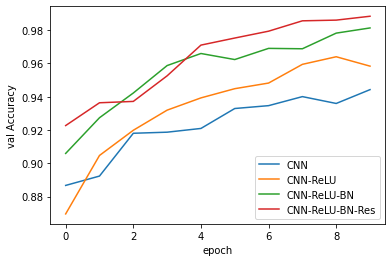

In [ ]:
sns.lineplot(x='epoch', y='val Accuracy', data=cnn_results, label='CNN')
sns.lineplot(x='epoch', y='val Accuracy', data=cnn_relu_results, label='CNN-ReLU')
sns.lineplot(x='epoch', y='val Accuracy', data=cnn_bn_results, label='CNN-ReLU-BN')
sns.lineplot(x='epoch', y='val Accuracy', data=cnn_res_results, label='CNN-ReLU-BN-Res')

With that said, it is hard to over-state how large an impact residual connections have had on modern deep learning. You will often see people refer to "ResNet-X" where the "X" stands for the total number of layers that are in a specific residual network architecture. This is because thousands of researchers and practitioners like to start with ResNet as their baseline, and add or remove a few parts to customize it to their own problem. In many cases, using ResNet with no change expect to the output layer gives a strong result on an image classification problem. As such it should become one of your go-to tools when tackling real life problems. 

# Long Short Term Memory RNNs

The RNN we have described and been using thus far is rarely used in practice. It is notoriously difficult to train and get working on more complex problems. You can find many different variants of RNNs being published, but the tired-and-true option that seems to always work well is called a Long Short Term Memory (LSTM) network. LSTMs are a type of RNN architecture originally developed in 1997! Despite their age (and a small tune-up in 2006), LSTMs have continued to be one of the best options available for a recurrent architecture.  

Lets quickly refresh what a simple RNN looks like with the below figure. We can describe it succinctly with its inputs $\boldsymbol{x}_t$ and the previous hidden state $\boldsymbol{h}_t$ being concatenated together whenever two lines merge. They get processed by a `nn.Linear` layer, go through the $\tanh$ non-linearity, and that becomes the output. 

![A simple RNN that we have learned from chapter 4. Information over time is captured in the hidden activations $\boldsymbol{h}_t$ that are feed into the next RNN layer, and are used as the output to any following layers. ](https://drive.google.com/uc?export=view&id=1fpeGlOHYqP5a3XHVgKBfjmzSt3Jy9Xuy)



One of the challenges with learning a RNN is that every time step performs some operations, and its hard to learn to save all the information you need from every preceding time step. This is a similar problem to what the Residual Layers were tackling, its easy for the gradient to send information back when there are less operations on it. 

This is part of how the LSTM helps to improve RNNs. An LSTM is going to create two sets of states, a hidden state $\boldsymbol{h}_t$ and a "context" state $\boldsymbol{C}_t$. $\boldsymbol{h}_t$ does the "work" and tries to learn complex functions, and the context $\boldsymbol{C}_t$ tries to simply "hold" valuable information for use at a later point in time. You can think of $\boldsymbol{C}_t$ as focusing on _long term_ information and  $\boldsymbol{h}_t$ as working on _short term_ information, hence, we get the name "Long Short Term" Memory. 

LSTMs make use of a strategy called _gating_ to make this happen. A _gating_ mechanism is one that produces a value in the range of $[0,1]$. That way if you multiply by the result of a gate, you can remove everything (the gate returned 0 and anything time 0 is 0) or allow everything to pass through (the gate returned 1). LSTMs are designed with three gates. 

1. The _forget gate_ that allows us to forget what is in out context $\boldsymbol{C}_t$. 
2. The _input gate_ controls what we want to add or "input" into the $\boldsymbol{C}_t$.
3. The _output gate_ which how much of the context $\boldsymbol{C}_t$  we want to include in the final output $\boldsymbol{h}_t$

The below figure shows what this looks like at a high level. 

![The strategy of an LSTM involves three gates that operate sequentially and allow interaction between the short term $\boldsymbol{h}_t$ and the long term $\boldsymbol{C}_t$. The forget gate in red, the input gate in blue, and the output gate in green.  ](https://drive.google.com/uc?export=view&id=1sg17-fm7MdNDHGUajmyZvTcjya9fM00V)



This gating is accomplished using the sigmoid $\sigma(\cdot)$ and $\tanh(\cdot)$ activation functions! Implementing gating mechanisms is one of the situations were you _want saturation_ because you need your outputs to be in a very specific range of values, so that you can create this _prior that some inputs need to be allowed, and some need to be stopped_. The sigmoid activation function $\sigma(\cdot)$, which will produce a value in the range of $[0, 1]$. If we take another value $\alpha$, and multiply it with the result of the sigmoid, we get $\boldsymbol{z} = \boldsymbol{\alpha} \cdot \sigma(\cdot)$. If $\sigma(\cdot)=0$, then we have essentially "close the gate" on $z$ containing any information about $\boldsymbol{\alpha}$. If $\sigma(\cdot)=1$, we have $\boldsymbol{z} = \boldsymbol{\alpha}$, and have essentially let all the information flow through the gate. For values in between, we end up "regulating" how much information/content from $\boldsymbol{\alpha}$ gets to flow through the network. We can see how an LSTM uses this gating approach in the below figure that shows the details of implementing one. 

![Diagram showing the detailed operations of an LSTM. The "$\times$" indicates two values being multiplied together , and the "$+$" shows values being added together. The same color coding of red for the forget gate, blue for the input gate, and green for the output gate apply, but show the details on how each gate is implemented and connected.  }](https://drive.google.com/uc?export=view&id=1BR6mZvbZUBxQkRkE1AJc4r00YM1FWhb5)


The context vector is on the top half and the short term hidden states on the bottom path. The set up has some reminiscent properties tot hat of the residual network we just learned about! The context $\boldsymbol{C}_t$ acts kind of like our residual path, having very few (and simple!) operations performed on it making it easier for the gradient to flow back over very long sequences. The bottom half of the LSTM does the heay lifting with linear layers and non-linear activation functions and attempts to learn more complex functions that are necessary, but also make it harder for the gradient to  propagate all the way through to the beginning. 

This idea of _gating_ and having a kind of short and long path is the main secret to making LSTMs work well and better than the simple RNN that we already learned about. Just like all RNNs, the LSTM also uses weight sharing over time. So we have looked at the LSTM cell for one input in time, and the same weights would be re-used for every item over time. The LSTM has a very thorough description and explanation provided [here](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) by Crhis Olah, who also describes some of the deeper details about _peephole connections_ which is a standard improvement in modern LSTMs. The Idea behind th peephole is to also concatenate the old context $\boldsymbol{C}_{t-1}$ into the `nn.Linear` layers that decide the forget fate and input gate, the idea being that you really should know what you are about to forget before making the decision to forget it! Similarly, adding it to the input gate helps you avoid adding redundant information you already have! Following this train of logic, one more peephole connection adds $\boldsymbol{C}_t$ to the last `nn.Linear` layer which gates the output, the idea being you should know what you are looking at outputting before deciding if you should output it! 

There are _tons_ of variants on the LSTM, including another popular RNN called the "Gated Recurrent unit" (GRU). However the LSTM with peephole connections has been a tried-and-true method that is hard to beat, and is what people are usually referring to when they say an "LSTM". 



Now that we have talked about what an LSTM is, lets implement one and try it! We will re-use the dataset and problem from chapter 4, were we try to predict the original language  a name might have come from.So first thing we will do is re setup that problem using the same code from before. 

In [ ]:
zip_file_url = "https://download.pytorch.org/tutorial/data.zip"

import requests, zipfile, io
r = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

#Zip file is organized as data/names/[LANG].txt , where [LANG] is a specific language

namge_language_data = {}

#We will use some code to remove UNICODE tokens to make life easy for us processing wise
#e.g., convert something like "Ślusàrski" to Slusarski
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
alphabet = {}
for i in range(n_letters):
    alphabet[all_letters[i]] = i
    
# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )


#Loop through every language, open the zip file entry, and read all the lines from the text file. 
for zip_path in z.namelist():
    if "data/names/" in zip_path and zip_path.endswith(".txt"):
        lang = zip_path[len("data/names/"):-len(".txt")]
        with z.open(zip_path) as myfile:
            lang_names = [unicodeToAscii(line).lower() for line in str(myfile.read(), encoding='utf-8').strip().split("\n")]
            namge_language_data[lang] = lang_names 

In [ ]:
dataset = LanguageNameDataset(namge_language_data, alphabet)

train_lang_data, test_lang_data = torch.utils.data.random_split(dataset, (len(dataset)-300, 300))
train_lang_loader = DataLoader(train_lang_data, batch_size=32, shuffle=True, collate_fn=pad_and_pack)
test_lang_loader = DataLoader(test_lang_data, batch_size=32, shuffle=False, collate_fn=pad_and_pack)

Now lets set up a new RNN as our baseline. I'm using a 3-layer one but I'm not making it bidirectional. While bidirectional layers help with the problem of getting information across time, I want to make that problem _worse_ so that we can better see the benefit of an LSTM. 

In [ ]:
rnn_3layer_bidir = nn.Sequential(
  EmbeddingPackable(nn.Embedding(len(all_letters), 64)), #(B, T) -> (B, T, D)
  nn.RNN(64, n, num_layers=3, batch_first=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
  LastTimeStep(rnn_layers=3), #We need to take the RNN output and reduce it to one item, (B, D)
  nn.Linear(n, len(namge_language_data)), #(B, D) -> (B, classes)
)

rnn_3layer_bidir.to(device)

Sequential(
  (0): EmbeddingPackable(
    (embd_layer): Embedding(57, 64)
  )
  (1): RNN(64, 256, num_layers=3, batch_first=True)
  (2): LastTimeStep()
  (3): Linear(in_features=256, out_features=18, bias=True)
)

In [ ]:
loss_func = nn.CrossEntropyLoss()

In [ ]:
rnn_results = train_network(rnn_3layer_bidir, loss_func, train_lang_loader, val_loader=test_lang_loader, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=10)

In [ ]:
lstm_3layer_bidir = nn.Sequential(
  EmbeddingPackable(nn.Embedding(len(all_letters), 64)), #(B, T) -> (B, T, D)
  nn.LSTM(64, n, num_layers=3, batch_first=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
  LastTimeStep(rnn_layers=3), #We need to take the RNN output and reduce it to one item, (B, D)
  nn.Linear(n, len(namge_language_data)), #(B, D) -> (B, classes)
)

lstm_3layer_bidir.to(device)

for p in lstm_3layer_bidir.parameters():
    p.register_hook(lambda grad: torch.clamp(grad, -5, 5))

lstm_results = train_network(lstm_3layer_bidir, loss_func, train_lang_loader, val_loader=test_lang_loader, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=10)

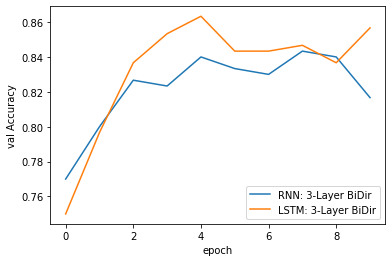

In [ ]:
sns.lineplot(x='epoch', y='val Accuracy', data=rnn_results, label='RNN: 3-Layer BiDir')
sns.lineplot(x='epoch', y='val Accuracy', data=lstm_results, label='LSTM: 3-Layer BiDir')

A good alternative for the LSTM is known as the "Gated Recurrent Unit" (GRU). We won't go into the details of the GRU, but its an intentional simplification of the LSTM design. If you have data that is shorter and simpler, or compute limitations are a concern, the GRU is worth checking out. It contains the better design approches like gating that make the LSTM learn better, while recuding the number of parameters that need to be learned. This makes if very effective for many tasks. 